<a href="https://colab.research.google.com/github/HakureiPOI/Network-Security-Lab-2025/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/HakureiPOI/Network-Security-Lab-2025.git

Cloning into 'Network-Security-Lab-2025'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 165 (delta 51), reused 108 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (165/165), 2.01 MiB | 5.31 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
!mkdir data

In [4]:
!cp -r Network-Security-Lab-2025/lenet_mnist_model.pth data/lenet_mnist_model.pth

In [5]:
!cp -r Network-Security-Lab-2025/retrained_model.pth data/retrained_model.pth

In [30]:
# epsilons = [0, .05, .08, .1, .15, .2, .25]
epsilons = [0, .04, .12, .24, .32]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=False

In [31]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [32]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [33]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [34]:
# Initialize the network
model = Net().to(device)

In [35]:
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [36]:
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [37]:
import torch

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [38]:
def test(model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [39]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.04	Test Accuracy = 9523 / 10000 = 0.9523
Epsilon: 0.12	Test Accuracy = 7943 / 10000 = 0.7943
Epsilon: 0.24	Test Accuracy = 2458 / 10000 = 0.2458
Epsilon: 0.32	Test Accuracy = 603 / 10000 = 0.0603


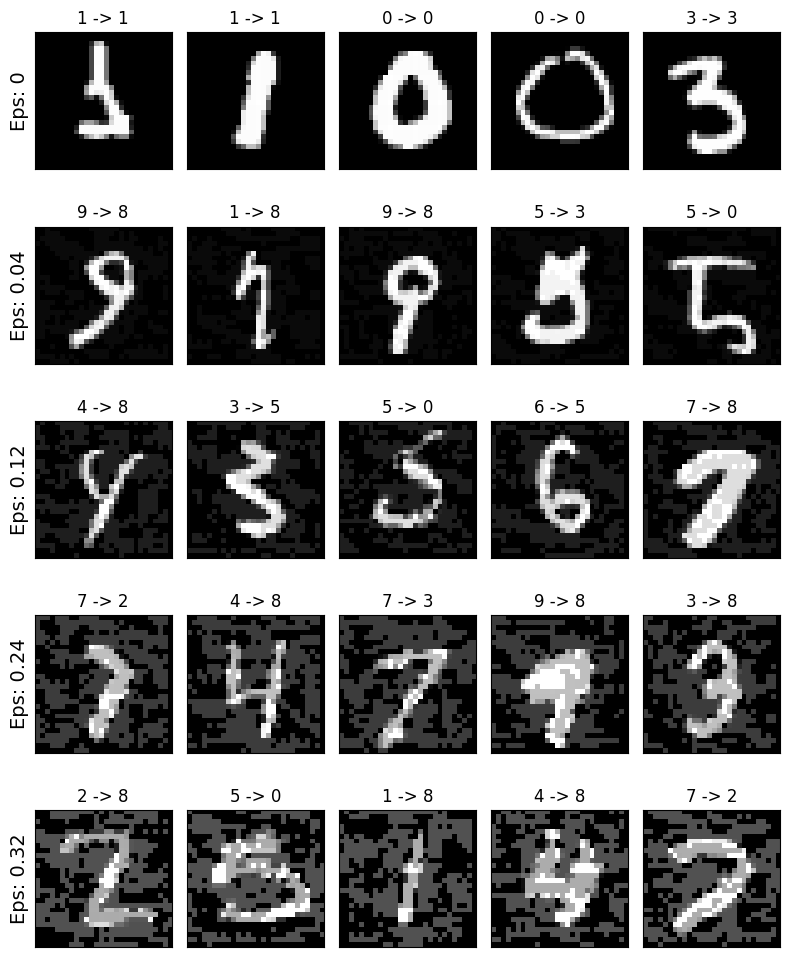

In [40]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [41]:
assert False

AssertionError: 

In [17]:
retrained_model_path = 'data/retrained_model.pth'

retrained_model = Net().to(device)

retrained_model.load_state_dict(torch.load(retrained_model_path, map_location='cpu'))

<All keys matched successfully>

In [18]:
def adversarial_train(model, device, train_loader, optimizer, epsilon):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        combined_data = torch.cat([data.detach(), perturbed_data.detach()], dim=0)
        combined_target = torch.cat([target, target], dim=0)

        output = model(combined_data)
        loss = F.nll_loss(output, combined_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Batch: {batch_idx}\tLoss: {loss.item():.6f}')

In [19]:
mnist_mean = 0.1307
mnist_std = 0.3081

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mnist_mean,), (mnist_std,))
        ])
    ),
    batch_size=64, shuffle=True
)

In [20]:
import torch.optim as optim


optimizer = optim.Adam(retrained_model.parameters(), lr=0.001)

In [26]:
for eps in epsilons:
    adversarial_train(retrained_model, device, train_loader, optimizer, eps)

Train Batch: 0	Loss: 0.108568
Train Batch: 100	Loss: 0.051927
Train Batch: 200	Loss: 0.092092
Train Batch: 300	Loss: 0.069574
Train Batch: 400	Loss: 0.169140
Train Batch: 500	Loss: 0.263385
Train Batch: 600	Loss: 0.268290
Train Batch: 700	Loss: 0.182454
Train Batch: 800	Loss: 0.179495
Train Batch: 900	Loss: 0.116203
Train Batch: 0	Loss: 0.168067
Train Batch: 100	Loss: 0.116497
Train Batch: 200	Loss: 0.163982
Train Batch: 300	Loss: 0.187538
Train Batch: 400	Loss: 0.146731
Train Batch: 500	Loss: 0.090610
Train Batch: 600	Loss: 0.159449
Train Batch: 700	Loss: 0.155937
Train Batch: 800	Loss: 0.109358
Train Batch: 900	Loss: 0.065872
Train Batch: 0	Loss: 0.077591
Train Batch: 100	Loss: 0.156610
Train Batch: 200	Loss: 0.139220
Train Batch: 300	Loss: 0.143528
Train Batch: 400	Loss: 0.110942
Train Batch: 500	Loss: 0.128432
Train Batch: 600	Loss: 0.230340
Train Batch: 700	Loss: 0.112897
Train Batch: 800	Loss: 0.151700
Train Batch: 900	Loss: 0.202241
Train Batch: 0	Loss: 0.070899
Train Batch: 100

In [27]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(retrained_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9496 / 10000 = 0.9496
Epsilon: 0.05	Test Accuracy = 9215 / 10000 = 0.9215
Epsilon: 0.08	Test Accuracy = 8886 / 10000 = 0.8886
Epsilon: 0.1	Test Accuracy = 8766 / 10000 = 0.8766
Epsilon: 0.15	Test Accuracy = 7949 / 10000 = 0.7949
Epsilon: 0.2	Test Accuracy = 7017 / 10000 = 0.7017
Epsilon: 0.25	Test Accuracy = 5945 / 10000 = 0.5945


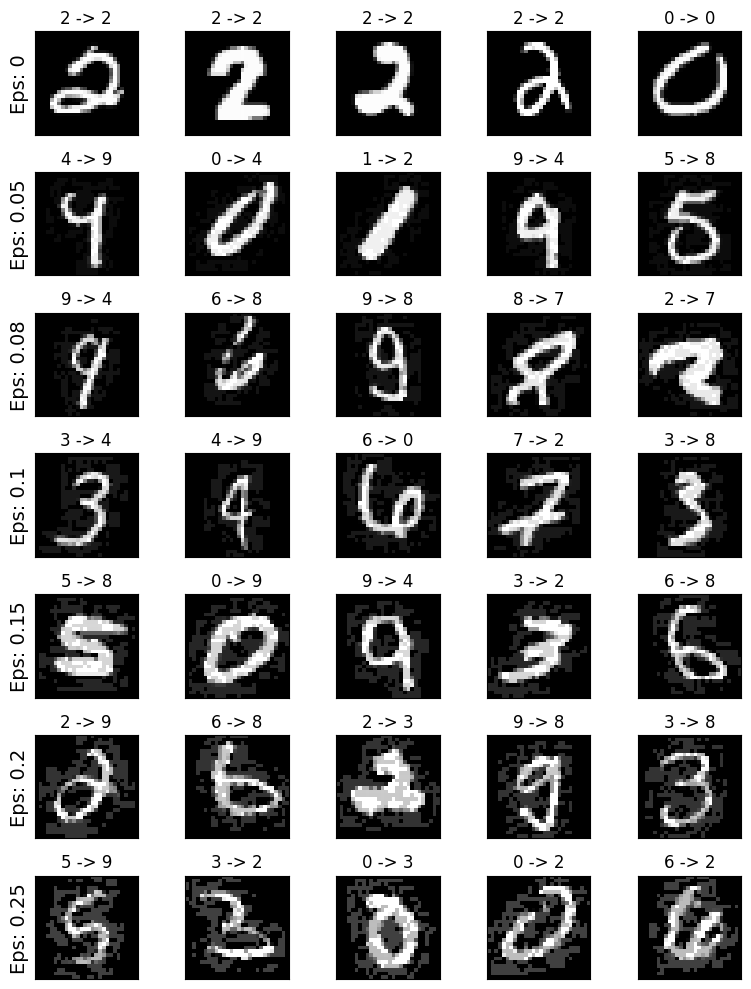

In [28]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [24]:
torch.save(retrained_model.state_dict(), 'retrained_model.pth')